In [9]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

Min gross_log: 3.00
Max gross_log: 21.80
Mean gross_log: 16.81


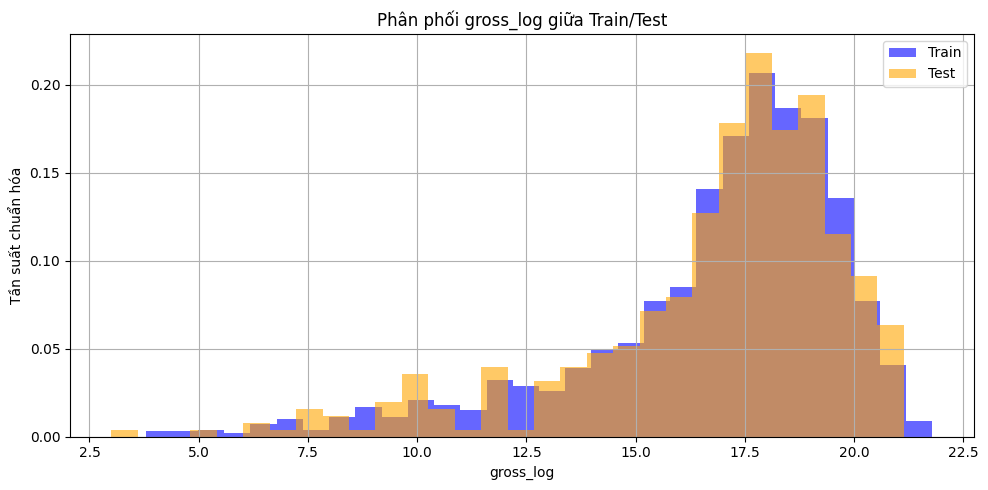

In [10]:
# Đọc dữ liệu
df = pd.read_csv("encoded_data.csv")

# Feature và target
X = df.drop(columns=['gross', 'gross_log'])
y = df['gross_log']

# Rời rạc hóa target thành 10 nhóm
y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Chia train/test với phân phối giống nhau
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X, y_binned):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thống kê
print(f"Min gross_log: {y.min():.2f}")
print(f"Max gross_log: {y.max():.2f}")
print(f"Mean gross_log: {y.mean():.2f}")

# Vẽ phân phối
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=30, alpha=0.6, label='Train', color='blue', density=True)
plt.hist(y_test, bins=30, alpha=0.6, label='Test', color='orange', density=True)
plt.title("Phân phối gross_log giữa Train/Test")
plt.xlabel("gross_log")
plt.ylabel("Tần suất chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#  Khởi tạo mô hình Gradient Boosting
model = GradientBoostingRegressor(
    n_estimators=100,        # Số lượng cây, thử giảm nếu quá lớn
    max_depth=3,             # Giới hạn chiều sâu của cây
    learning_rate=0.05,       # Điều chỉnh tốc độ học
    min_samples_split=10,    # Điều chỉnh số mẫu tối thiểu cho mỗi split
    min_samples_leaf=5,      # Điều chỉnh số mẫu tối thiểu cho mỗi lá
    random_state=42
)

In [12]:
# Huấn luyện mô hình với dữ liệu huấn luyện
model.fit(X_train, y_train)

# Dự đoán trên tập huấn luyện và kiểm thử
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Đánh giá mô hình với RMSE và R²
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Training RMSE: 1.7362
Test RMSE: 2.0194
Training R²: 0.6801
Test R²: 0.5769


In [13]:
# Tạo KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách lưu kết quả
rmse_list, mse_list, mae_list, r2_list = [], [], [], []

print("📊 Cross-validation results:")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_val_cv)

    rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Fold {fold}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# In kết quả trung bình
print("\n📈 Average Cross-validation Performance:")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MSE:  {np.mean(mse_list):.4f}")
print(f"Avg MAE:  {np.mean(mae_list):.4f}")
print(f"Avg R²:   {np.mean(r2_list):.4f}")

📊 Cross-validation results:
Fold 1: RMSE=2.0426, MSE=4.1723, MAE=1.3840, R²=0.5635
Fold 2: RMSE=2.0942, MSE=4.3858, MAE=1.3703, R²=0.5586
Fold 3: RMSE=2.0185, MSE=4.0742, MAE=1.3519, R²=0.6092
Fold 4: RMSE=1.8328, MSE=3.3593, MAE=1.2409, R²=0.6154
Fold 5: RMSE=1.8635, MSE=3.4726, MAE=1.2615, R²=0.5976

📈 Average Cross-validation Performance:
Avg RMSE: 1.9703
Avg MSE:  3.8928
Avg MAE:  1.3217
Avg R²:   0.5889
